In [200]:
setwd("../datasets/")
data <- read.table (file="HR_prediction-all.csv",sep=",", header=T)

In [201]:
nb_instances <- nrow(data)
nb_attributes <- ncol(data)

qualitatives_attributes_col_idx <- c(7,9,10,11)
target_variables_idx <- 8

In [202]:
nb_instances
nb_attributes

[1] 10000

[1] 11

In [203]:
summary(data)

       Id        satisfaction_level last_evaluation  number_project 
 Min.   :    3   Min.   :0.090      Min.   :0.3600   Min.   :2.000  
 1st Qu.: 3728   1st Qu.:0.440      1st Qu.:0.5600   1st Qu.:3.000  
 Median : 7434   Median :0.640      Median :0.7200   Median :4.000  
 Mean   : 7471   Mean   :0.614      Mean   :0.7176   Mean   :3.799  
 3rd Qu.:11243   3rd Qu.:0.820      3rd Qu.:0.8700   3rd Qu.:5.000  
 Max.   :14999   Max.   :1.000      Max.   :1.0000   Max.   :7.000  
 average_montly_hours time_spend_company Work_accident         left       
 Min.   : 96.0        Min.   : 2.000     Min.   :0.0000   Min.   :0.0000  
 1st Qu.:156.0        1st Qu.: 3.000     1st Qu.:0.0000   1st Qu.:0.0000  
 Median :199.0        Median : 3.000     Median :0.0000   Median :0.0000  
 Mean   :200.7        Mean   : 3.494     Mean   :0.1459   Mean   :0.2381  
 3rd Qu.:245.0        3rd Qu.: 4.000     3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :310.0        Max.   :10.000     Max.   :1.0000   Max.   :1

In [204]:
# SRC :https://www.geeksforgeeks.org/how-to-find-and-count-missing-values-in-r-dataframe/
# find location of missing values
print("Position of missing values ")
which(is.na(data))
 
# count total missing values 
print("Count of total missing values  ")
sum(is.na(data))

#SRC : https://www.datacamp.com/doc/r/missingdata
# list rows of data that have missing values
data[!complete.cases(data),]

[1] "Position of missing values "


integer(0)

[1] "Count of total missing values  "


[1] 0

Id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>


In [205]:
# SRC :https://stat.ethz.ch/R-manual/R-devel/library/base/html/unique.html
#SRC https://www.statology.org/r-loop-through-data-frame-columns/
# Methods 1
sapply(data[, qualitatives_attributes_col_idx], unique)

$Work_accident
[1] 0 1

$promotion_last_5years
[1] 0 1

$department
 [1] "marketing"   "sales"       "accounting"  "product_mng" "support"    
 [6] "technical"   "IT"          "management"  "hr"          "RandD"      

$salary
[1] "medium" "low"    "high"

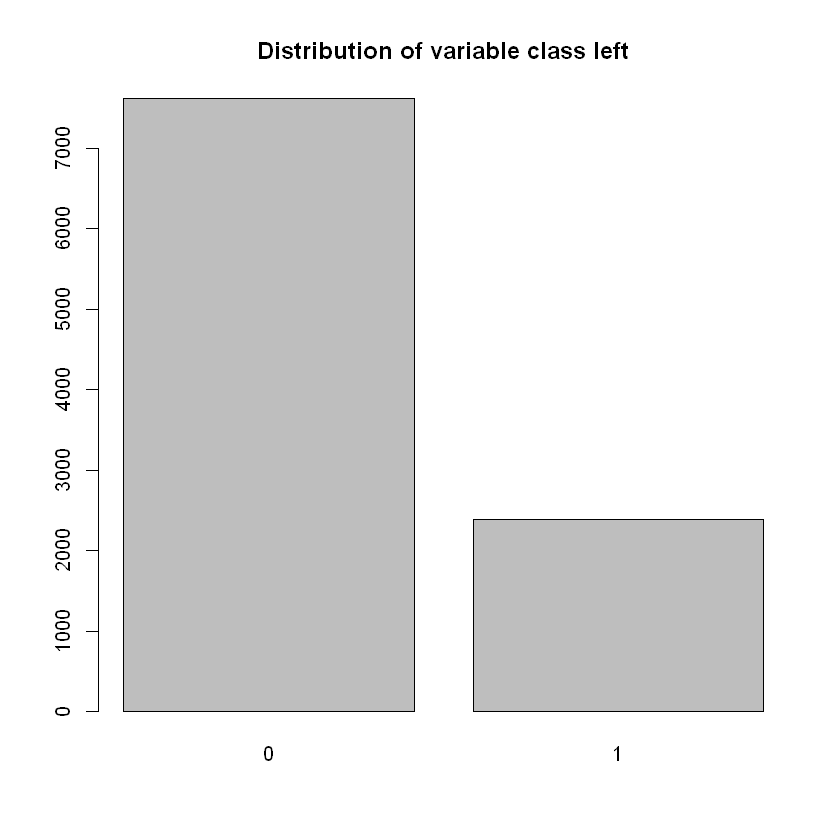

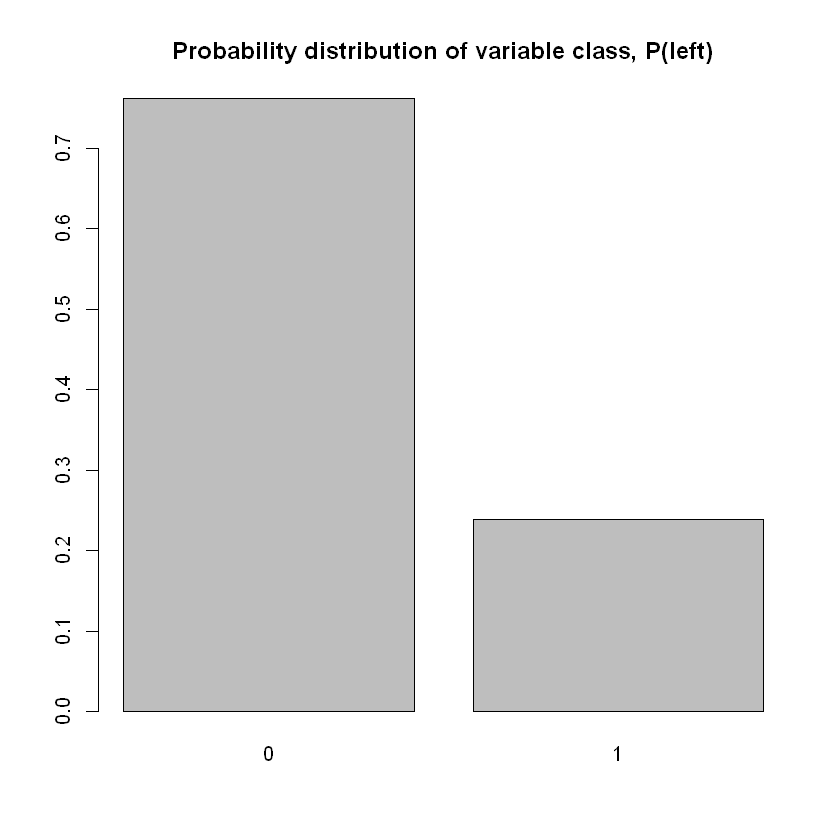

In [206]:
target.counts <- table(data[, target_variables_idx])
P.target <- prop.table(target.counts)
barplot(target.counts, main=paste0("Distribution of variable class ", colnames(data)[target_variables_idx]))
barplot(P.target, main=paste0("Probability distribution of variable class, P(", colnames(data)[target_variables_idx], ")"))


In [207]:
# Define the function
plot_probabilities <- function(data, variable_idx, target_idx) {


    # Get the names of the variable and target variable
    var_name <- trimws(colnames(data)[variable_idx])
    target_name <- trimws(colnames(data)[target_idx])
    
    # Calculate the probability distribution P(variable)
    P_var <- prop.table(table(data[, variable_idx]))
    print(P_var)  # Display the probability distribution
        
    # Calculate the conditional probability P(target|variable)
    # Observing employe who left the company among the employe who had a work accident instance
    # P(left=1 | work_accident = 1)
    P_target_given_var <- prop.table(table(data[, c(target_idx, variable_idx)]), margin = 2)
    print(P_target_given_var)  # Display the conditional probability

    # Set working directory to the folder of the script
    #setwd(normalizePath(dirname(sys.frame(1)$ofile)))
    setwd("C:/Users/huniv/jnotebook/data-mining/62-62_Data_Mining/tp01/")
  
    # Ensure output directory exists
    if (!dir.exists("./output")) {
        dir.create("./output")
    }
  
    # Create the full path for the PDF file
    full_pdf_path <- file.path("./output", paste0(var_name, ".pdf"))
  
    # Open a PDF to save the plots
    pdf(file = paste(full_pdf_path), width = 12, height = 6)

    # Set up a 1-row, 2-column layout for the plots
    par(mfrow = c(1, 2), mar = c(5, 4, 4, 6) + 0.1)  # Adjust margins for better space for the legend
  
    # Visualize the probability distribution P(variable)
    barplot(P_var, 
            main = paste0("Probability Distribution P(", var_name, ")"), 
            xlab = paste0("Category of ", var_name), 
            ylab = "Probability"
    ) 
    #legend = TRUE,
    #args.legend = list(x = "topright", inset = c(-0.1, 0), bty = "n")
    
    # Visualize the conditional probability P(target|variable)
    barplot(P_target_given_var, 
            beside = FALSE,  # Separate bars for each target category
            main = paste0("Conditional Probability P(", target_name, "|", var_name, ")"), 
            xlab = paste0("Category of ", var_name), 
            ylab = "Conditional Probability", 
            legend.text = rownames(P_target_given_var),
            args.legend = list(x = "topright", inset = c(-0.1, 0), bty = "n")
    )
    
    # Close the PDF device
    dev.off()
    
}

In [208]:
# Define the index of the variable and target variable
for (i in qualitatives_attributes_col_idx) {
    plot_probabilities(data, i, target_variables_idx)
}


     0      1 
0.8541 0.1459 
    Work_accident
left          0          1
   0 0.73492565 0.91980809
   1 0.26507435 0.08019191

     0      1 
0.9789 0.0211 
    promotion_last_5years
left          0          1
   0 0.75799367 0.94312796
   1 0.24200633 0.05687204

         IT       RandD  accounting          hr  management   marketing 
     0.0825      0.0524      0.0517      0.0503      0.0420      0.0551 
product_mng       sales     support   technical 
     0.0608      0.2790      0.1481      0.1781 
    department
left        IT     RandD accounting        hr management marketing product_mng
   0 0.7793939 0.8587786  0.7272727 0.7335984  0.8452381 0.7676951   0.7976974
   1 0.2206061 0.1412214  0.2727273 0.2664016  0.1547619 0.2323049   0.2023026
    department
left     sales   support technical
   0 0.7494624 0.7461175 0.7422796
   1 0.2505376 0.2538825 0.2577204

  high    low medium 
0.0790 0.4885 0.4325 
    salary
left       high        low     medium
   0 0.93924051 0.700

In [212]:
QualitativeAttrsTheory <- function(data, variable_idx, target_idx) {
        
    var_name <- trimws(colnames(data)[variable_idx])
    target_name <- trimws(colnames(data)[target_idx])
    
    # Calculate the joint probability distribution
    title <- paste("P(",var_name,",",target_name,")")
    P.var.target <- prop.table(table(data[,c(variable_idx,target_idx)]))
    barplot(P.var.target, main=title, legend=T)
  
    print("P(target, var):")
    print(P.var.target)
    print("########################")
    
    # Caculate marginale distribution P(Target)
    print("P(target):")
    P.target <- colSums(P.var.target)
    print("Check:")
    print(prop.table(table(data[,target_idx])))
    print(P.target)
    print("########################")

    # Caculate marginale distribution P(Variable)
    print("P(var):")
    P.var <- rowSums(P.var.target)
    print("Check:")
    print(prop.table(table(data[,variable_idx])))
    print(P.var)
    print("########################")
   
    P.target.given.var <- sweep(P.var.target,1,P.var, FUN="/")
    print("P(target|var):")
    print(P.target.given.var)
    print("Check:")
    print(rowSums(P.target.given.var))
    print("########################")

    P.var.given.target <- sweep(P.var.target,2,P.target, FUN="/")
    print("P(var|target):")
    print(P.var.given.target)
    print("Check:")
    print(colSums(P.var.given.target))
    print("########################")
}

[1] "P(target, var):"
             left
department         0      1
  IT          0.0643 0.0182
  RandD       0.0450 0.0074
  accounting  0.0376 0.0141
  hr          0.0369 0.0134
  management  0.0355 0.0065
  marketing   0.0423 0.0128
  product_mng 0.0485 0.0123
  sales       0.2091 0.0699
  support     0.1105 0.0376
  technical   0.1322 0.0459
[1] "########################"
[1] "P(target):"
[1] "Check:"

     0      1 
0.7619 0.2381 
     0      1 
0.7619 0.2381 
[1] "########################"
[1] "P(var):"
[1] "Check:"

         IT       RandD  accounting          hr  management   marketing 
     0.0825      0.0524      0.0517      0.0503      0.0420      0.0551 
product_mng       sales     support   technical 
     0.0608      0.2790      0.1481      0.1781 
         IT       RandD  accounting          hr  management   marketing 
     0.0825      0.0524      0.0517      0.0503      0.0420      0.0551 
product_mng       sales     support   technical 
     0.0608      0.2790      0.1

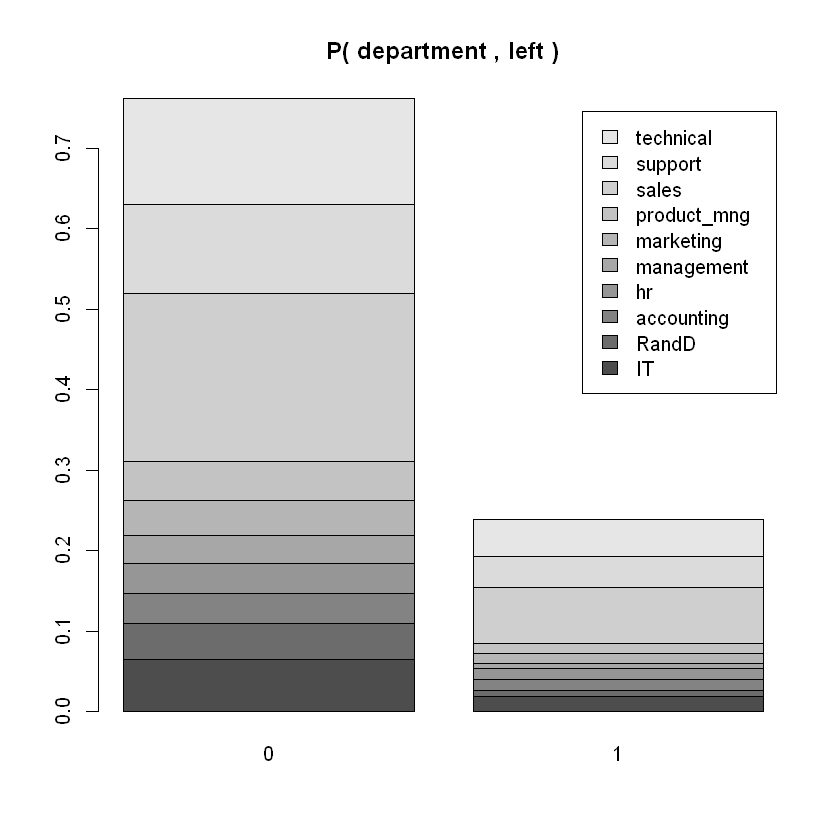

In [213]:
    QualitativeAttrsTheory(data, 10,target_variables_idx)